# Interpretability techniques for single samples from RVL-CDIP subset - LayoutLMVV3

## GITHUB

In [1]:
!git clone https://github.com/adamserag1/Interpretability-for-VRDU-models.git

Cloning into 'Interpretability-for-VRDU-models'...
remote: Enumerating objects: 700, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 700 (delta 32), reused 32 (delta 14), pack-reused 634 (from 1)
Receiving objects: 100% (700/700), 15.58 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (368/368), done.


In [29]:
!git pull https://github.com/adamserag1/Interpretability-for-VRDU-models.git

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 333 bytes | 333.00 KiB/s, done.
From https://github.com/adamserag1/Interpretability-for-VRDU-models
 * branch            HEAD       -> FETCH_HEAD
Updating c0bd344..adc0f3a
Fast-forward
 Eval/fidelity.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [2]:
%cd /content/Interpretability-for-VRDU-models

/content/Interpretability-for-VRDU-models


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Libraries

In [4]:
#code
from datasets import load_from_disk
from transformers import LayoutLMv3ForSequenceClassification, AutoProcessor, BrosModel, AutoTokenizer
import sys
import importlib
def reload_modules():
    for module in list(sys.modules.keys()):
        if module.startswith('vrdu_utils') or module.startswith('Classification_Explain') or module.startswith('lime') or module.startswith('Eval'):
            print(f"Reloading module: {module}")
            importlib.reload(sys.modules[module])

reload_modules()

from vrdu_utils.encoders import *
from Classification_Explain.lime import *
from vrdu_utils.utils import *
import torch
from Eval.eval_suite import *
from Eval.fidelity import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
from transformers import logging as hf_logging

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="transformers.modeling_utils",   # the module that emits the msg
)
hf_logging.set_verbosity_error()

## Data + Model Setup

In [5]:
from google.colab import drive
drive.mount("/content/drive")
!cp -r /content/drive/MyDrive/THESIS/rvl_cdip_financial_subset /content

Mounted at /content/drive


In [53]:
rvl = load_from_disk('/content/rvl_cdip_financial_subset')
dataset_split = rvl.train_test_split(test_size=0.2, seed=42)
val = dataset_split["test"]
val_ds = DocSampleDataset(val)

# Extract samples 'agree' (LLMV3 + BROS classify correct) and 'CLASH' (LLMV3 classify wrong, BROS classify correct)

AGREE = val_ds[846] # (contents, idx)
CLASH = val_ds[119] # (contents, idx)

In [54]:
AGREE[0].label

4

In [55]:
CLASH[0].label

4

### BROSforDocumentClassifcation classifier head


In [ ]:
from torch import nn
class BrosForDocumentClassification(BrosPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bros = BrosModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        bbox=None,
        attention_mask=None,
        token_type_ids=None,
        labels=None,
        **kwargs
    ):
        outputs = self.bros(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Use the [CLS] token's representation (first token)
        cls_output = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return {
            "loss": loss,
            "logits": logits,
        }

### Model config

In [30]:
LLMV3 = LayoutLMv3ForSequenceClassification.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz",
                                                            num_labels=5,
                                                            id2label={0: "form", 1: "invoice", 2: "budget", 3: "file folder", 4: "questionnaire"},
                                                            label2id={"form": 0, "invoice": 1, "budget": 2, "file folder": 3, "questionnaire": 4})
LLMV3_proc = AutoProcessor.from_pretrained("adamadam111/layoutlmv3-docclass-finetuned-frz", apply_ocr=False)
LLMV3_encode = make_layoutlmv3_encoder(LLMV3_proc)
LLMV3.to(device)

bros_config = AutoConfig.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    num_labels=5,
    id2label={0: "form", 1: "invoice", 2: "budget", 3: "file folder", 4: "questionnaire"},
    label2id={"form": 0, "invoice": 1, "budget": 2, "file folder": 3, "questionnaire": 4}
)

BROS = BrosForDocumentClassification.from_pretrained(
    "adamadam111/bros-docclass-finetuned-frz",
    config=bros_config
)
BROS_t = AutoTokenizer.from_pretrained("adamadam111/bros-docclass-finetuned-frz",do_lower_case=True)
BROS_encode = make_bros_encoder(BROS_t)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

LayoutLMv3ForSequenceClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Enco

## Interpreting the 'CLASH' sample

### Text Modality

--------------------------
| BROS_lime | LLMV3_lime |
| BROS_shap | LLMV3_shap |
--------------------------

In [2]:

text_explainers = {
    'BROS lime' : LimeTextExplaienr(BROS, BROS_t, mask_token=BROS_t.mask_token, kernel_width_factor = 0.75, labels=[0]),
    'LLMV3 lime' : LimeTextExplainer(LLMV3, LLMV3_encode, mask_token = LLMV3_proc.tokenizer.mask_token, kernel_width_factor = 0.75, labels = [0]),
    'BROS shap' : SHAPTextExplainer(BROS, BROS_t, mask_token=BROS_t.mask_token, device=device, algorithm='partition'),
    'LLMV3 shap' : SHAPTextExplainer(LLMV3, LLMV3_proc, mask_token=LLMV3_proc.tokenizer.mask_token, device=device, algorithm='partition')
}

NameError: name 'LimeTextExplainer' is not defined

In [ ]:
shap_text_explainations = {key : explainer.explain(CLASH[0], num_samples = 2000) for key, explainer in text_explainers.items() if }


In [57]:
text_explainer = LimeTextExplainer(
    LLMV3,
    LLMV3_encode,
    mask_token = LLMV3_proc.tokenizer.mask_token,
    batch_size = 2,
    kernel_width_factor = 0.75,
    labels = [4]
)

In [59]:
text_vals = text_explainer.explain(AGREE[0], align_boxes=True, num_samples=2000, num_features=30)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE
MADE PREDICT


[LIME] - Text: 100%|██████████| 1000/1000 [01:07<00:00, 14.85it/s]


In [61]:
print("Explanation score (R²):", text_vals.score)
for word, weight in text_vals.as_list(label=4):
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.5400323868604897
TESTING=1  -> +0.3205282359
PERMIT=1   -> -0.2453773293
CIRCLE=1   -> +0.1232844989
09/14/00=1 -> -0.1213931989
7592605030=1 -> -0.1209888985
LEGAL=1    -> -0.1035435944
CHANGED=1  -> -0.0964325781
Date=1     -> -0.0920091476
FAX=1      -> -0.0919534823
phrases=1  -> +0.0746460957
VIRGINA=1  -> -0.0709158064
Ballot=1   -> +0.0688230427
01516960=1 -> -0.0609925024
CONSUMER=1 -> +0.0608734673
77=1       -> +0.0560616357
CHANGE=1   -> -0.0554682898
18042744780=1 -> -0.0534544893
each=1     -> +0.0481802885
Q=1        -> +0.0478539118
22014=1    -> -0.0478075509
P.O.=1     -> +0.0469367506
Due=1      -> -0.0458769306
PRODUCT=1  -> -0.0441783156
listed=1   -> +0.0435822464
the=1      -> +0.0428622151
OR=1       -> +0.0402991049
11:22=1    -> -0.0399912225
JOHN=1     -> -0.0357928618
LONG=1     -> +0.0328746740
a=1        -> +0.0315960852


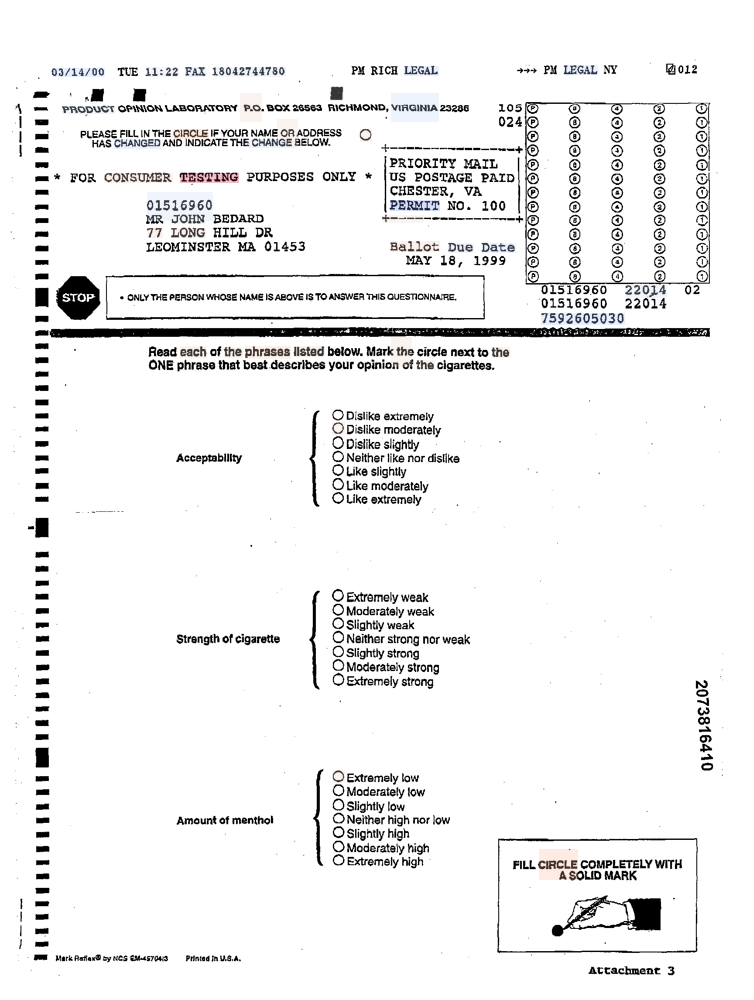

In [63]:
from vrdu_utils.utils import draw_lime_token_heatmap
import re
weights = {}
for token, w in text_vals.as_list(label=4):
    clean = re.sub(r"=\d+$", "", token)     # drop '=number' suffix
    weights[clean] = weights.get(clean, 0.0) + w

draw_lime_token_heatmap(image = AGREE[0].image, words = AGREE[0].words, boxes = AGREE[0].bboxes, weights = weights, alpha = 0.25)

In [64]:
fe_text = FidelityEvaluator(
    model = LLMV3,
    encode_fn = LLMV3_encode,
    device = device,
    mask_token = LLMV3_proc.tokenizer.mask_token
)

In [15]:
len(AGREE[0].words)

41

In [110]:
top20 = sorted(weights, key=weights.get, reverse=True)[: int(len(weights)*0.2)]

print("LIME feature strings:", top20[:10])
print("First 20 words in sample:", AGREE[0].words[:20])

# quick overlap check
print("Overlap size:",
      len({f.split('=')[0] for f in top20}.intersection(AGREE[0].words)))

LIME feature strings: ['Cost', 'handling', '$49.82', '$49.32', '$23.35,', '$23.95']
First 20 words in sample: ['Imperial', 'Tact]', 'L', 'Cost', '|', '5706|_$47.37', '$49.32', '|', '|', '5726|', '$47.37', '$49.82', '|', '|', '—5746|', '$47.37', '$49.32', '_|', '5756|', '$47.37']
Overlap size: 6


In [111]:
orig = fe_text._get_prediction_function(AGREE[0].label)(AGREE[0])
pert = fe_text._get_prediction_function(AGREE[0].label)(
            DocSample(image=AGREE[0].image, words=["[UNK]"]*len(AGREE[0].words),
                      bboxes=AGREE[0].bboxes, ner_tags=AGREE[0].ner_tags, label=AGREE[0].label))
print(f"p_orig  = {orig:.6f}")
print(f"p_allUNK= {pert:.6f}")

p_orig  = 0.999919
p_allUNK= 0.000055


In [65]:
scores = fe_text.evaluate(
    sample          = AGREE[0],
    explanation     = weights,
    top_k_fraction  = 0.2,          # use 20 % of the most important tokens
)
print(scores)
# {'$49.82', '$23.35', '$47.37', '$49.92,', '$23.35,', 'Cost', 'Imperial', '$49.32', 'handling', '$23.95'}
# {'$49.82', '$23.35', '$47.37', '$23.35,', 'Cost', 'Imperial', '$49.32', 'handling', '$23.95'}

dict_items([('TESTING', 0.3205282359193263), ('PERMIT', -0.24537732930020018), ('CIRCLE', 0.12328449890107587), ('09/14/00', -0.1213931988633826), ('7592605030', -0.12098889847925068), ('LEGAL', -0.10354359444888225), ('CHANGED', -0.09643257809098012), ('Date', -0.09200914757371348), ('FAX', -0.09195348232135804), ('phrases', 0.07464609571952292), ('VIRGINA', -0.07091580644369469), ('Ballot', 0.0688230427130549), ('01516960', -0.060992502389710615), ('CONSUMER', 0.060873467319759254), ('77', 0.056061635661395395), ('CHANGE', -0.055468289752155286), ('18042744780', -0.05345448929443866), ('each', 0.0481802885151693), ('Q', 0.04785391175292557), ('22014', -0.04780755093980096), ('P.O.', 0.04693675062595101), ('Due', -0.045876930620211864), ('PRODUCT', -0.04417831562019167), ('listed', 0.043582246366153064), ('the', 0.042862215108855135), ('OR', 0.040299104889327954), ('11:22', -0.03999122252246325), ('JOHN', -0.03579286181732051), ('LONG', 0.032874674032047205), ('a', 0.03159608518628525

## Layout

In [34]:
layout_explainer = LimeLayoutExplainer(
    LLMV3,
    LLMV3_encode,
    batch_size = 4,
    mask_token = LLMV3_proc.tokenizer.mask_token,
    labels = [2]
)

layout_vals = layout_explainer.explain(AGREE[0], num_samples=2000, num_features=15)

Begging EXPLAINER
Begging EXPLAIN_INSTANCE


[LIME] - Text: 100%|██████████| 500/500 [01:07<00:00,  7.37it/s]


In [35]:
print("Explanation score (R²):", layout_vals.score)
for word, weight in layout_vals.as_list(label=2):
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.6335363879344521
allowance=1 -> -0.3230508231
Cost=1     -> +0.1804153072
5706|_$47.37=1 -> -0.1418403051
$23.35=1   -> +0.1026391179
receive=1  -> -0.0953625741
.50/m=1    -> -0.0791968010
$49.82=1   -> +0.0667180885
$23.95=1   -> +0.0639275558
‘Cost=1    -> +0.0590320484
—5746|=1   -> +0.0572607868
Rothman.=1 -> -0.0556882580
a=1        -> -0.0548015402
istomers=1 -> +0.0497032673
$23.35,=1  -> +0.0496243980
$49.32=1   -> +0.0436027145


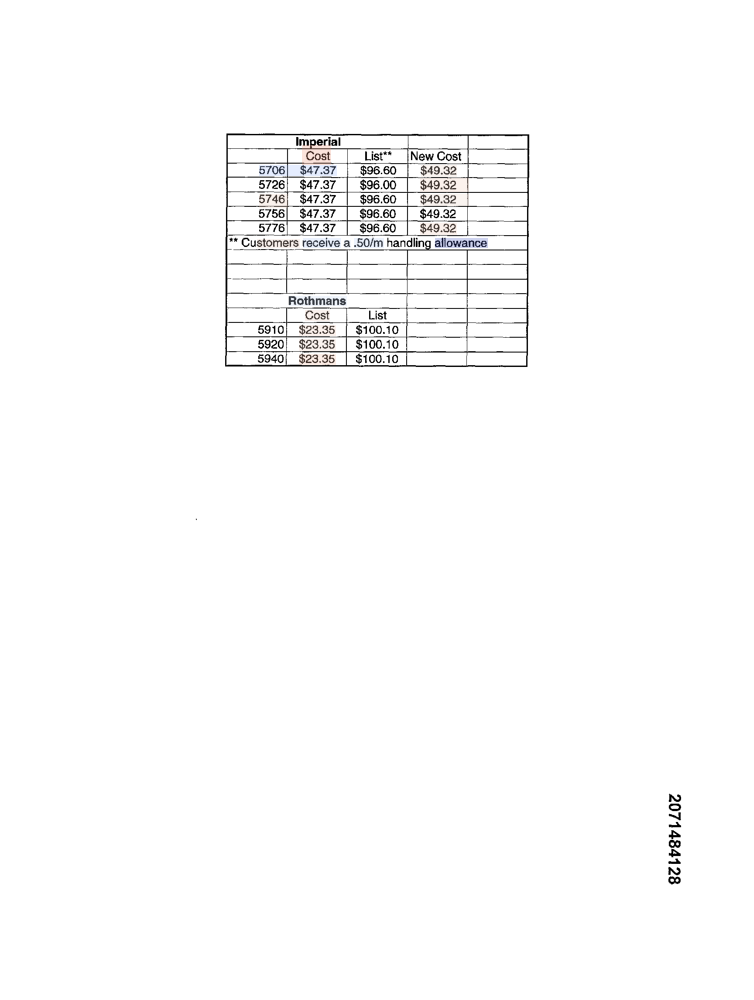

In [36]:
from vrdu_utils.utils import draw_lime_token_heatmap
import re
weights = {}
for token, w in layout_vals.as_list(label=2):
    clean = re.sub(r"=\d+$", "", token)     # drop '=number' suffix
    weights[clean] = weights.get(clean, 0.0) + w

draw_lime_token_heatmap(image = AGREE[0].image, words = AGREE[0].words, boxes = AGREE[0].bboxes, weights = weights, alpha = 0.25)

### Vision

In [49]:
vision_explainer = LimeVisionExplainer(
    LLMV3,
    LLMV3_encode,
    batch_size=4,
    label = 2
)

vision_vals = vision_explainer.explain(AGREE[0], num_samples=10000, num_features=10)

  0%|          | 0/10000 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

[LIME] - VISION:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print("Explanation score (R²):", vision_vals.score)

In [ ]:
segment_weights = dict(vision_vals.local_exp[2])

# Create weight map
segments = vision_vals.segments
weight_map = np.zeros_like(segments, dtype=float)
for seg_id, weight in segment_weights.items():
    weight_map[segments == seg_id] = weight

# Define overlay function
def lime_weight_to_overlay(image_np, weight_map, alpha=0.4):
    max_weight = np.max(np.abs(weight_map))
    if max_weight == 0:
        max_weight = 1
    normalized_weights = weight_map / max_weight
    r = np.where(normalized_weights > 0, 255,
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    g = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255 * (1 + normalized_weights), 255))
    b = np.where(normalized_weights > 0, 255 * (1 - normalized_weights),
                 np.where(normalized_weights < 0, 255, 255))
    color_map = np.stack([r, g, b], axis=-1).astype(np.uint8)
    overlay = ((1 - alpha) * image_np + alpha * color_map).clip(0, 255).astype(np.uint8)
    return overlay

# Apply overlay
img_np = vision_vals.image
heat_np = lime_weight_to_overlay(img_np, weight_map, alpha=0.4)

# Display
Image.fromarray(heat_np)

In [81]:
from PIL import Image

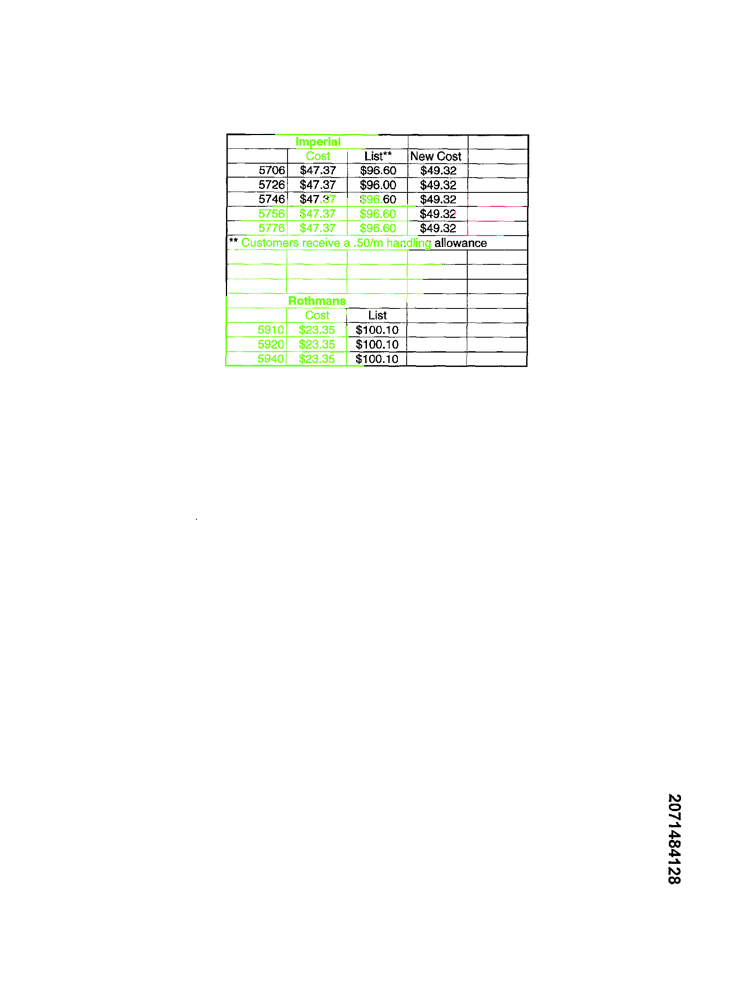

In [102]:
img_np, mask = vision_vals.get_image_and_mask(
    label = 2,
    positive_only=False,   # include negative weights too
    num_features=30,
    hide_rest=False
)

heat_np = lime_mask_to_overlay(img_np, mask, alpha=0.40)
Image.fromarray(heat_np)

In [74]:
print("Explanation score (R²):", vision_vals.score)
for word, weight in vision_vals:
  print(f"{word:10s} -> {weight:+.10f}")

Explanation score (R²): 0.4999955177896892


TypeError: 'ImageExplanation' object is not iterable